In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('burglaries_preprocessed.csv')
data = data[['Month', 'Ward']]#, 'Season']]

In [3]:
data

,Month,Ward
0,2010-12,High Barnet
1,2010-12,High Barnet
2,2010-12,High Barnet
3,2010-12,High Barnet
4,2010-12,High Barnet
...,...,...
42986,2023-03,Childs Hill
42987,2023-03,Childs Hill
42988,2023-03,Childs Hill
42989,2023-03,Childs Hill


In [4]:
def reg_evaluation(y_test, y_pred, ward: str):    
    print(f'Results for {ward}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
#     print('R2 score:', round(r2_score(y_test, y_pred),2))
    print('Weighted mean absolute percentage error:', 
          round(np.abs(y_test - y_pred).sum() / np.abs(y_test).sum(),2))
    print('\n')

### Fix the imputation below after adding features!!

In [5]:
def create_features(df):
    '''set index to datetime, create temporal features
    '''

    df = df.set_index('Month')
    df.index = pd.to_datetime(df.index)
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['crime_count'] = 1
    
    return df

data = create_features(data)

In [6]:
def return_year_month(row): 
    '''created for convenience later on
    '''
    return str(row['year']) + '-' + str(row['month'])

In [7]:
data

,Ward,month,year,crime_count
Month,,,,
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
...,...,...,...,...
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1


In [8]:
data_aggr = data.groupby(['year', 'month', 'Ward']).count()
data_aggr.reset_index(inplace=True)

# aggregate to get crimes per month, per ward in each row

In [9]:
data_aggr.loc[450:500]

,year,month,Ward,crime_count
450,2012,6,Totteridge & Woodside,12
451,2012,6,Underhill,21
452,2012,6,West Finchley,23
453,2012,6,West Hendon,16
454,2012,6,Whetstone,19
455,2012,6,Woodhouse,27
456,2012,7,Barnet Vale,12
457,2012,7,Brunswick Park,10
458,2012,7,Burnt Oak,19
459,2012,7,Childs Hill,26


In [10]:
data_aggr['year_month'] = data_aggr.apply(return_year_month, axis=1)
data_aggr['date'] = data_aggr['year_month']
data_aggr = data_aggr.set_index('date')
data_aggr.index = pd.to_datetime(data_aggr.index)

In [11]:
data_aggr

,year,month,Ward,crime_count,year_month
date,,,,,
2010-12-01,2010,12,Barnet Vale,13,2010-12
2010-12-01,2010,12,Brunswick Park,13,2010-12
2010-12-01,2010,12,Burnt Oak,9,2010-12
2010-12-01,2010,12,Childs Hill,17,2010-12
2010-12-01,2010,12,Colindale North,7,2010-12
...,...,...,...,...,...
2023-03-01,2023,3,Underhill,1,2023-3
2023-03-01,2023,3,West Finchley,13,2023-3
2023-03-01,2023,3,West Hendon,9,2023-3


# Imputation of months w/o crime data

In [12]:
# collect the wards with a missing month

wards_wo_month = []

for month in data_aggr['Ward'].unique():
    if data_aggr[data_aggr['Ward']==month].shape[0]<148:        
        wards_wo_month.append(month)

In [13]:
# get the missing month for each of the wards

all_months = data_aggr.index.unique().to_list()
dct_impute = {}

for ward in wards_wo_month:
    
    lst_months=[]
    
    for i, row in data_aggr[data_aggr['Ward']==ward].iterrows():
        lst_months.append(i)
        dct_impute[ward] = list(set(all_months) - set(lst_months))[0]


In [14]:
dct_impute

{'Colindale North': Timestamp('2014-12-01 00:00:00'),
 'Colindale South': Timestamp('2016-10-01 00:00:00'),
 'Edgwarebury': Timestamp('2021-07-01 00:00:00'),
 'High Barnet': Timestamp('2022-12-01 00:00:00'),
 'Totteridge & Woodside': Timestamp('2021-05-01 00:00:00'),
 'Whetstone': Timestamp('2023-01-01 00:00:00'),
 'Woodhouse': Timestamp('2020-08-01 00:00:00')}

# Adjust cell to match changes in features!


In [15]:
# imputing all values for the missing months

data_aggr = data_aggr.append(pd.DataFrame({'year':2014, 'month':12, 'Ward':'Colindale North',# 'Season':'Winter', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale North']['crime_count'].mean()), 
                                           'year_month':'2014-12'}, index=[dct_impute['Colindale North']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2016, 'month':10, 'Ward':'Colindale South',# 'Season':'Autumn', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale South']['crime_count'].mean()), 
                                           'year_month':'2016-10'}, index=[dct_impute['Colindale South']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':7, 'Ward':'Edgwarebury',# 'Season':'Summer', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Edgwarebury']['crime_count'].mean()), 
                                           'year_month':'2021-7'}, index=[dct_impute['Edgwarebury']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2022, 'month':12, 'Ward':'High Barnet',# 'Season':'Winter', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='High Barnet']['crime_count'].mean()), 
                                           'year_month':'2022-12'}, index=[dct_impute['High Barnet']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':5, 'Ward':'Totteridge & Woodside',# 'Season':'Spring', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Totteridge & Woodside']['crime_count'].mean()), 
                                           'year_month':'2021-5'}, index=[dct_impute['Totteridge & Woodside']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2023, 'month':1, 'Ward':'Whetstone',# 'Season':'January', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Whetstone']['crime_count'].mean()), 
                                           'year_month':'2023-1'}, index=[dct_impute['Whetstone']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2020, 'month':8, 'Ward':'Woodhouse',# 'Season':'Summer', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Woodhouse']['crime_count'].mean()), 
                                           'year_month':'2020-8'}, index=[dct_impute['Woodhouse']]))

In [16]:
data_aggr['timestamp']=data_aggr.index
data_aggr.sort_index(inplace=True)

In [17]:
print('Mean burglary count per month in Barnet:', data_aggr.crime_count.mean())

Mean burglary count per month in Barnet: 12.119932432432432


In [18]:
# data_aggr.to_csv('data_aggregated.csv')

In [19]:
data_aggr

,year,month,Ward,crime_count,year_month,timestamp
2010-12-01,2010,12,Barnet Vale,13,2010-12,2010-12-01
2010-12-01,2010,12,Woodhouse,10,2010-12,2010-12-01
2010-12-01,2010,12,Whetstone,9,2010-12,2010-12-01
2010-12-01,2010,12,West Hendon,13,2010-12,2010-12-01
2010-12-01,2010,12,West Finchley,27,2010-12,2010-12-01
...,...,...,...,...,...,...
2023-03-01,2023,3,Childs Hill,20,2023-3,2023-03-01
2023-03-01,2023,3,Burnt Oak,13,2023-3,2023-03-01
2023-03-01,2023,3,Brunswick Park,13,2023-3,2023-03-01
2023-03-01,2023,3,Golders Green,13,2023-3,2023-03-01


# XGBoost


In [20]:
def data_split_1_ward(data, ward, end_train, end_val):
    '''A single model can only handle the time series of a single ward
       This function prepares the data to train a model on a single ward
    ''' 
    
    FEATURES = ['month']
    TARGET = 'crime_count'
    
    WARD = ward
    data_1w = data[data['Ward']==WARD]
    
    train_1w = data_1w.loc[data_1w.index < end_train]
    val_1w = data_1w.loc[(data_1w.index >= end_train) & (data_1w.index < end_val)]
    test_1w = data_1w.loc[data_1w.index >= end_val]
    
    X_train_1w = train_1w[FEATURES]
    y_train_1w = train_1w[TARGET]

    X_val_1w = val_1w[FEATURES]
    y_val_1w = val_1w[TARGET]

    X_test_1w = test_1w[FEATURES]
    y_test_1w = test_1w[TARGET]
    
    return X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w

In [21]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.02)

In [22]:
mae = 0
rmse = 0
r2 = 0
wmape = 0

for ward in data_aggr['Ward'].unique():
    
    X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w = data_split_1_ward(
    data_aggr, ward, '2021-10-01', '2022-03-01')

    reg.fit(X_train_1w, y_train_1w, eval_set=[(X_val_1w, y_val_1w)], verbose=200)
    
    reg_evaluation(y_test_1w, reg.predict(X_test_1w), ward)
    
    mae += mean_absolute_error(y_test_1w, reg.predict(X_test_1w))
    rmse += mean_squared_error(y_test_1w, reg.predict(X_test_1w))
    r2 += r2_score(y_test_1w, reg.predict(X_test_1w))
    wmape += np.abs(y_test_1w - reg.predict(X_test_1w)).sum() / np.abs(y_test_1w).sum()
    
mae /= 24
rmse /= 24
rmse = np.sqrt(rmse)
r2 /= 24
wmape /= 24

[18:50:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.10816
[69]	validation_0-rmse:6.86023
Results for Barnet Vale:
Mean Absolute Error: 2.21
Root Mean Squared Error: 2.74
Weighted mean absolute percentage error: 0.37


[18:50:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.60810
[109]	validation_0-rmse:3.08927
Results for Woodhouse:
Mean Absolute Error: 2.38
Root Mean Squared Error: 2.87
Weighted mean absolute percentage error: 0.4


[18:50:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.27070
[82]	validation_0-rmse:5.13481
Results for Whetstone:
Mean Ab

[115]	validation_0-rmse:6.21003
Results for Burnt Oak:
Mean Absolute Error: 3.38
Root Mean Squared Error: 4.65
Weighted mean absolute percentage error: 0.29


[18:51:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.42471
[92]	validation_0-rmse:4.39596
Results for Brunswick Park:
Mean Absolute Error: 2.61
Root Mean Squared Error: 3.11
Weighted mean absolute percentage error: 0.37


[18:51:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12.69313
[118]	validation_0-rmse:3.10999
Results for Finchley Church End:
Mean Absolute Error: 3.12
Root Mean Squared Error: 3.49
Weighted mean absolute percentage error: 0.28




In [23]:
print('Metrics for XGB w/o MLForecast')
print('MAE:', mae)
print('RMSE:', rmse)
print('WMAPE:', wmape)
# print('R2:', r2)

Metrics for XGB w/o MLForecast
MAE: 3.061583006993318
RMSE: 4.053730272246795
WMAPE: 0.3482965036601287


### Split data for DeepAR and XGB w/ MLForecast


In [24]:
train = data_aggr.loc[(data_aggr.index >= '2010-03-01') & (data_aggr.index < '2022-03-01')]
train2 = data_aggr.loc[(data_aggr.index >= '2020-03-01') & (data_aggr.index < '2022-03-01')]
test = data_aggr.loc[data_aggr.index >= '2022-03-01']

## XGB with MLForecast (unfinished)

In [25]:
dct_idx = dict(zip(list(test['year_month'].unique()), [i for i in range(1, len(test['year_month'].unique())+1)]))
test_MLF = test.replace({"year_month": dct_idx})

In [26]:
from mlforecast import MLForecast

from window_ops.rolling import rolling_mean, rolling_max, rolling_min


reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.0001)

model = MLForecast(models=reg2,
                   freq='M',
                   lags=[1, 12],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_max, 3), (rolling_min, 3)],},
                   num_threads=4)


model.fit(train2[['month','crime_count','Ward']], id_col='Ward', time_col='month', target_col='crime_count', 
        static_features=[])

C:\Users\Goshko\anaconda3\lib\site-packages\mlforecast\core.py:218: UserWarning: Setting `freq=1` since time col is int.
  warnings.warn("Setting `freq=1` since time col is int.")


[18:51:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag12', 'rolling_mean_lag1_window_size3', 'rolling_max_lag1_window_size3', 'rolling_min_lag1_window_size3'], date_features=[], num_threads=4)

In [27]:
# collecting predictions 

p = model.predict(horizon=test_MLF['timestamp'].nunique())
p['year_month'] = p['month']
p.drop(columns=['month'], inplace=True)
p['year_month'] = p['year_month']-12
p = p.merge(test_MLF[['Ward', 'timestamp', 'year_month', 'crime_count']], on=['Ward', 'year_month'], how='left')

In [28]:
p[['Ward', 'XGBRegressor', 'crime_count', 'timestamp']].loc[:12]

,Ward,XGBRegressor,crime_count,timestamp
0,Barnet Vale,9.458283,7,2022-03-01
1,Barnet Vale,6.653607,7,2022-04-01
2,Barnet Vale,7.923960,7,2022-05-01
3,Barnet Vale,7.096425,11,2022-06-01
4,Barnet Vale,7.096425,6,2022-07-01
5,Barnet Vale,6.375953,3,2022-08-01
6,Barnet Vale,6.375953,4,2022-09-01
7,Barnet Vale,3.673456,4,2022-10-01
8,Barnet Vale,4.317351,5,2022-11-01
9,Barnet Vale,5.014837,9,2022-12-01


# DeepAR

In [48]:
def wmape(y_true, y_pred):
    '''Weighted Mean Absolute Percentage Error
    '''
    
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [49]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='crime_count', item_id='Ward', 
                                       timestamp='year_month', freq='M')

In [70]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=12, num_layers=3, lr=0.002, context_length=24,
                            trainer_kwargs={'max_epochs':8})

predictor = estimator.train(train_ds, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 36.4 K | ?        | [1, 100, 12]
----------------------------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.146     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 3.10000 (best 3.10000), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_100\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2.83694 (best 2.83694), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_100\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.81141 (best 2.81141), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_100\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 2.76894 (best 2.76894), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_100\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 2.75130 (best 2.75130), saving model to 'C:\\Users\

In [71]:
# collect predictions

pred = list(predictor.predict(train_ds))
all_preds = list()
for ward in pred:
    ward_name = ward.item_id
    p = ward.samples.mean(axis=0)
    # making an 80% confidence interval
    p10 = np.percentile(ward.samples, 10, axis=0)
    p90 = np.percentile(ward.samples, 90, axis=0)
    dates = pd.date_range(start=ward.start_date.to_timestamp(), periods=len(p), freq='M')
    dates2 = []
    for month in dates:
        day_num = month.strftime("%d")
        month_reset = month - timedelta(days=int(day_num) - 1)
        dates2.append(month_reset)
    ward_pred = pd.DataFrame({'timestamp': dates2, 'Ward': ward_name, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [ward_pred]

all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(test, on=['timestamp', 'Ward'], how='left')

In [72]:
all_preds

,timestamp,Ward,pred,p10,p90,year,month,crime_count,year_month
0,2022-03-01,Barnet Vale,6.237403,2.379637,9.456125,2022,3,7,2022-3
1,2022-04-01,Barnet Vale,6.285754,3.081110,9.438208,2022,4,7,2022-4
2,2022-05-01,Barnet Vale,6.284451,2.696147,10.004658,2022,5,7,2022-5
3,2022-06-01,Barnet Vale,6.422218,3.297135,10.155058,2022,6,11,2022-6
4,2022-07-01,Barnet Vale,6.268939,3.021670,9.277581,2022,7,6,2022-7
...,...,...,...,...,...,...,...,...,...
283,2022-10-01,Woodhouse,7.386641,4.449622,11.248109,2022,10,8,2022-10
284,2022-11-01,Woodhouse,8.077960,4.058956,12.594459,2022,11,15,2022-11
285,2022-12-01,Woodhouse,8.017242,4.371086,11.638945,2022,12,7,2022-12
286,2023-01-01,Woodhouse,6.897745,2.134719,11.010032,2023,1,4,2023-1


In [73]:
wmape(all_preds['crime_count'], all_preds['pred'])

0.332273582995884

In [74]:
reg_evaluation(all_preds['crime_count'], all_preds['pred'], 'all wards')

Results for all wards:
Mean Absolute Error: 2.91
Root Mean Squared Error: 3.86
Weighted mean absolute percentage error: 0.33




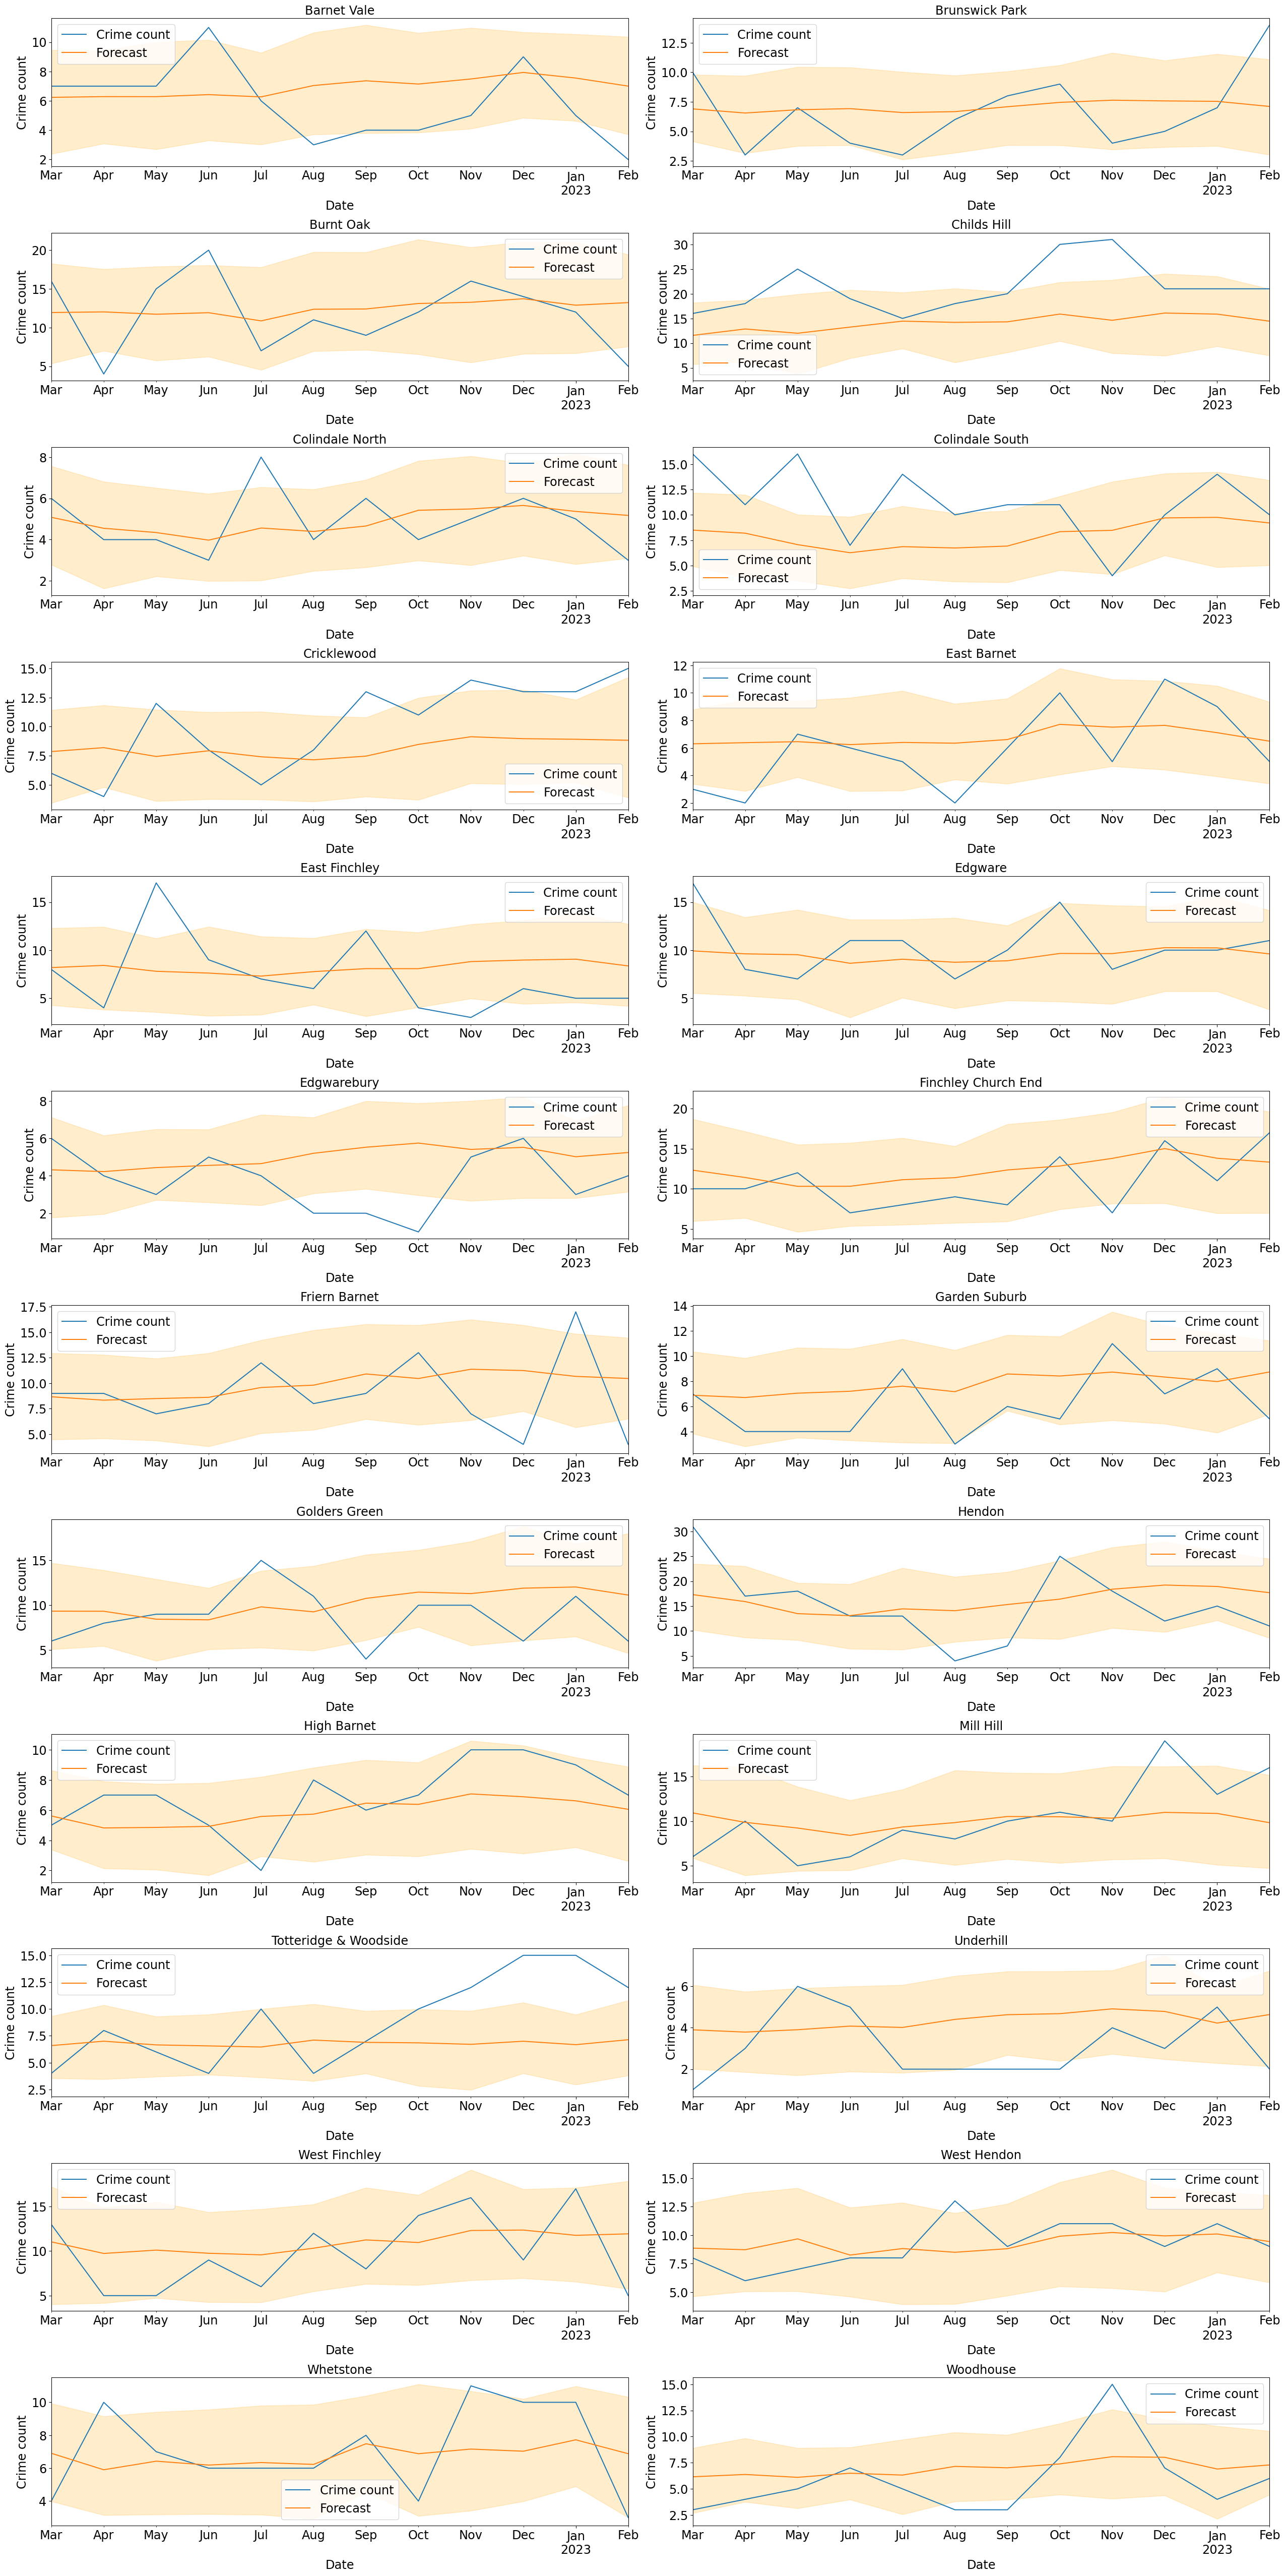

In [75]:
fig, ax = plt.subplots(12,2, figsize=(2*1280/96, 4*1280/96), dpi=96)
ax = ax.flatten()

for ax_ ,ward in enumerate(all_preds['Ward'].unique()):
    p_ = all_preds.loc[all_preds['Ward'] == ward]
    p_.plot(x='timestamp', y='crime_count', ax=ax[ax_], label='Crime count')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(ward, fontsize=18)
    ax[ax_].legend(fontsize=18)
    ax[ax_].set_xlabel('Date', fontsize=18)
    ax[ax_].set_ylabel('Crime count', fontsize=18)
    ax[ax_].tick_params(axis='both', which='major', labelsize=18)
    ax[ax_].tick_params(axis='both', which='minor', labelsize=18)

    
fig.tight_layout()

# Allocation Algorithm

In [37]:
all_preds[['year','month', 'timestamp', 'Ward', 'crime_count', 'pred']]

,year,month,timestamp,Ward,crime_count,pred
0,2022,3,2022-03-01,Barnet Vale,7,6.430735
1,2022,4,2022-04-01,Barnet Vale,7,6.774162
2,2022,5,2022-05-01,Barnet Vale,7,6.277559
3,2022,6,2022-06-01,Barnet Vale,11,5.980634
4,2022,7,2022-07-01,Barnet Vale,6,6.101390
...,...,...,...,...,...,...
283,2022,10,2022-10-01,Woodhouse,8,6.276025
284,2022,11,2022-11-01,Woodhouse,15,6.401893
285,2022,12,2022-12-01,Woodhouse,7,6.652499
286,2023,1,2023-01-01,Woodhouse,4,5.909807


In [46]:
area_dct = {'Underhill': 0.0003302356307330862,
 'High Barnet': 0.0010549626589272468,
 'West Hendon': 0.0004086562316890823,
 'Cricklewood': 0.00025934190989339957,
 'Colindale South': 0.00019869650062657944,
 'Childs Hill': 0.00038096246250333076,
 'Garden Suburb': 0.0005547058257849817,
 'Finchley Church End': 0.00038934048995135386,
 'East Finchley': 0.0003185855120878877,
 'Edgwarebury': 0.0009324781144551859,
 'Mill Hill': 0.0010234358185738756,
 'Totteridge & Woodside': 0.0012412965180637187,
 'Whetstone': 0.00030998167350423537,
 'Friern Barnet': 0.0003580645520225484,
 'Brunswick Park': 0.00039438509954705585,
 'East Barnet': 0.0005035355399889798,
 'Burnt Oak': 0.0003298030671537467,
 'Hendon': 0.00043475121773897815,
 'West Finchley': 0.0003164277592351248,
 'Barnet Vale': 0.0004573917511400428,
 'Edgware': 0.00043409307504250236,
 'Colindale North': 0.0001359910396524823,
 'Golders Green': 0.0002129278437282144,
 'Woodhouse': 0.00028580111061825584}

def allocate(prev_index,index):
        alloc.loc[prev_index:index, 'officers_allocated'] = (alloc.loc[prev_index:index, 'area'] / alloc.loc[prev_index:index, 'area'].sum()) 
        alloc.loc[prev_index:index, 'officers_allocated'] *= (alloc.loc[prev_index:index, 'pred'] / alloc.loc[prev_index:index, 'crime_count'].sum()) 
        alloc.loc[prev_index:index, 'officers_allocated'] /= alloc.loc[prev_index:index, 'officers_allocated'].sum()
        alloc.loc[prev_index:index, 'officers_allocated'] *= 100
            

# create appropriate columns and sort
alloc = all_preds[['year','month', 'timestamp', 'Ward', 'crime_count', 'pred']]
alloc['area'] = alloc['Ward'].map(area_dct)
alloc = alloc.dropna(subset=['area'])
alloc = alloc.sort_values('timestamp').reset_index(drop = True)
alloc['officers_allocated'] = 0
    
prev_index = 0
for i in range(len(alloc.index)-1):
    if alloc.loc[i, 'month'] != alloc.loc[i+1, 'month'] or i+1 > len(alloc)-2:
        index = i 
        allocate(prev_index, index)
        prev_index = index

C:\Users\Goshko\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
alloc[alloc['timestamp'] == '2022-04-01']

,year,month,timestamp,Ward,crime_count,pred,area,officers_allocated
24,2022,4,2022-04-01,Cricklewood,4,8.213536,0.000259,2.419287
25,2022,4,2022-04-01,East Barnet,2,6.392607,0.000504,3.655886
26,2022,4,2022-04-01,East Finchley,4,8.489956,0.000319,3.071963
27,2022,4,2022-04-01,Woodhouse,4,5.867210,0.000286,1.904496
28,2022,4,2022-04-01,Brunswick Park,3,6.275290,0.000394,2.810857
29,2022,4,2022-04-01,Edgware,8,8.767051,0.000434,4.322360
30,2022,4,2022-04-01,Edgwarebury,4,4.372136,0.000932,4.630381
31,2022,4,2022-04-01,Whetstone,10,4.853175,0.000310,1.708624
32,2022,4,2022-04-01,Finchley Church End,10,10.819575,0.000389,4.784365
33,2022,4,2022-04-01,Barnet Vale,7,6.774162,0.000457,3.519074
